In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import os
import pandas as pd
import numpy as np
import math
import datetime as dt
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GRU
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from tensorflow.keras.optimizers import Adam


#Librerías optimizacion por búsqueda aleatoria
from tensorflow.keras.callbacks import EarlyStopping
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from sklearn.model_selection import RandomizedSearchCV


from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
maindf = pd.read_csv(r"/content/XAUUSD_D1.csv", sep="\t", parse_dates=["Time"], dayfirst=True)

In [ ]:
maindf['Time'] = pd.to_datetime(maindf['Time'], format='%Y-%m-%d')

maindf = maindf.loc[(maindf['Time'] >= '2006-12-31')
                     & (maindf['Time'] <= '2022-12-01')]


In [ ]:
# Separamos los valores de cierre
closedf = maindf[['Time','Close']]
print("Shape de closedf:", closedf.shape)

Shape de closedf: (4961, 2)


In [ ]:
close_stock = closedf.copy()
print("Total data for prediction: ",closedf.shape[0])

Total data for prediction:  4961


In [ ]:
del closedf['Time']
scaler=MinMaxScaler(feature_range=(0,1))
closedf=scaler.fit_transform(np.array(closedf).reshape(-1,1))
print(closedf.shape)

(4961, 1)


In [ ]:
training_size=int(len(closedf)*0.75)
test_size=len(closedf)-training_size
train_data,test_data=closedf[0:training_size,:],closedf[training_size:len(closedf),:1]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (3720, 1)
test_data:  (1241, 1)


In [ ]:
# Convierte un array de valores en un matriz dataset
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [ ]:
time_step = 5
train_X, train_y = create_dataset(train_data, time_step)
test_X, test_y = create_dataset(test_data, time_step)

print("X_train: ", train_X.shape)
print("y_train: ", train_y.shape)
print("X_test: ", test_X.shape)
print("y_test", test_y.shape)

X_train:  (3714, 5)
y_train:  (3714,)
X_test:  (1235, 5)
y_test (1235,)


In [ ]:
# reshape input to be [samples, time steps, features] which is required for LSTM
train_X =train_X.reshape(train_X.shape[0],train_X.shape[1] , 1)
test_X = test_X.reshape(test_X.shape[0],test_X.shape[1] , 1)

print("X_train: ", train_X.shape)
print("X_test: ", test_X.shape)

X_train:  (3714, 5, 1)
X_test:  (1235, 5, 1)


In [ ]:
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.activations import tanh

def create_model(n_layers, n_neurons, dropout_rate, lr):
    model = Sequential()
    for i in range(n_layers):
        if i == 0:
            model.add(GRU(n_neurons, input_shape=train_X.shape[1:], return_sequences=True))
        else:
            model.add(GRU(n_neurons, return_sequences=True))
        model.add(Dropout(dropout_rate))
    model.add(GRU(n_neurons))
    model.add(Dense(1, activation='linear'))
    optimizer = Adam(lr=lr)
    model.compile(loss='mse', optimizer=optimizer)
    return model

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

def objective(n_layers, dropout_rate, n_neurons, lr):
    n_layers = round(n_layers)
    n_neurons = round(n_neurons)
    model = create_model(n_layers, dropout_rate, n_neurons, lr)
    early_stop = EarlyStopping(monitor='val_loss', patience=5, mode='min')
    model.fit(train_X, train_y, epochs=100, validation_split=0.1, callbacks=[early_stop], verbose=0)
    loss = -model.evaluate(test_X, test_y, verbose=0)
    return loss

In [ ]:
# Definimos los límites de los hiperparámetros

param_dist = {
    'n_layers': sp_randint(1, 6),
    'n_neurons': sp_randint(32, 150),
    'dropout_rate': sp_uniform(loc=0.0, scale=0.99),
    'lr': sp_uniform(loc=1e-10, scale=1e-2)
}

In [ ]:
n_iter_search = 20
random_search = RandomizedSearchCV(estimator=KerasRegressor(build_fn=create_model), param_distributions=param_dist, n_iter=n_iter_search, cv=3)


<ipython-input-15-b904e0e7cb97>:2: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  random_search = RandomizedSearchCV(estimator=KerasRegressor(build_fn=create_model), param_distributions=param_dist, n_iter=n_iter_search, cv=3)


In [ ]:
import joblib
# Esto ejecuta la celda en varios núcleos de CPU
with joblib.parallel_backend('multiprocessing', n_jobs=-1):
    random_search.fit(train_X, train_y)

39/39 [==============================] - 4s 13ms/step - loss: 0.0369


39/39 [==============================] - 2s 7ms/step - loss: 0.0120


66/78 [========================>.....] - ETA: 0s - loss: 0.0327

39/39 [==============================] - 3s 14ms/step - loss: 2.6319e-04


39/39 [==============================] - 2s 7ms/step - loss: 1.4010e-04


39/39 [==============================] - 5s 11ms/step - loss: 0.0437


39/39 [==============================] - 5s 8ms/step - loss: 0.0036


71/78 [==========================>...] - ETA: 0s - loss: 0.0407

39/39 [==============================] - 2s 6ms/step - loss: 0.0260


72/78 [==========================>...] - ETA: 0s - loss: 0.0307

39/39 [==============================] - 2s 6ms/step - loss: 1.2414e-04


39/39 [==============================] - 4s 15ms/step - loss: 5.0075e-04


39/39 [==============================] - 4s 20ms/step - loss: 6.9847e-04


39/39 [==============================] - 2s 9ms/step - loss: 0.0161


39/39 [==============================] - 4s 17ms/step - loss: 1.8140e-04


39/39 [==============================] - 4s 11ms/step - loss: 3.8133e-04


19/78 [======>.......................] - ETA: 1s - loss: 0.0639

39/39 [==============================] - 3s 7ms/step - loss: 0.0060


42/78 [===============>..............] - ETA: 1s - loss: 0.0269

39/39 [==============================] - 2s 6ms/step - loss: 1.9976e-04


39/39 [==============================] - 2s 8ms/step - loss: 0.0049


39/39 [==============================] - 3s 7ms/step - loss: 5.8883e-04


39/39 [==============================] - 2s 8ms/step - loss: 9.1107e-05


39/39 [==============================] - 5s 14ms/step - loss: 4.0707e-04


39/39 [==============================] - 4s 21ms/step - loss: 3.7988e-04


39/39 [==============================] - 3s 15ms/step - loss: 2.8844e-04


39/39 [==============================] - 5s 10ms/step - loss: 0.0096


39/39 [==============================] - 3s 10ms/step - loss: 4.3530e-04


39/39 [==============================] - 4s 10ms/step - loss: 1.8493e-04


39/39 [==============================] - 3s 11ms/step - loss: 0.0125


39/39 [==============================] - 3s 11ms/step - loss: 0.0015


78/78 [==============================] - 23s 63ms/step - loss: 0.0192


39/39 [==============================] - 3s 11ms/step - loss: 0.0040


39/39 [==============================] - 5s 14ms/step - loss: 4.2116e-04


39/39 [==============================] - 5s 12ms/step - loss: 1.5059e-04


39/39 [==============================] - 7s 10ms/step - loss: 0.0114


39/39 [==============================] - 4s 11ms/step - loss: 6.7415e-04


39/39 [==============================] - 4s 9ms/step - loss: 1.2404e-04


39/39 [==============================] - 6s 46ms/step - loss: 2.5985e-04


39/39 [==============================] - 8s 31ms/step - loss: 4.8823e-04


39/39 [==============================] - 5s 33ms/step - loss: 1.1723e-04


39/39 [==============================] - 6s 9ms/step - loss: 0.0227


39/39 [==============================] - 3s 7ms/step - loss: 0.0016


39/39 [==============================] - 1s 6ms/step - loss: 0.0340


39/39 [==============================] - 3s 8ms/step - loss: 7.8493e-04


39/39 [==============================] - 2s 6ms/step - loss: 0.0077


39/39 [==============================] - 1s 6ms/step - loss: 1.4640e-04


39/39 [==============================] - 3s 9ms/step - loss: 0.0062


39/39 [==============================] - 1s 5ms/step - loss: 0.0011


39/39 [==============================] - 2s 8ms/step - loss: 8.0653e-05


36/78 [============>.................] - ETA: 1s - loss: 0.0142

39/39 [==============================] - 2s 7ms/step - loss: 3.0538e-04


39/39 [==============================] - 2s 8ms/step - loss: 9.6344e-05


39/39 [==============================] - 4s 12ms/step - loss: 0.0171


39/39 [==============================] - 5s 13ms/step - loss: 7.0688e-04


39/39 [==============================] - 2s 16ms/step - loss: 8.0744e-04


39/39 [==============================] - 6s 12ms/step - loss: 1.2308e-04


39/39 [==============================] - 3s 20ms/step - loss: 6.4595e-04


117/117 [==============================] - 22s 72ms/step - loss: 0.0089


In [ ]:
print("Mejores parametros encontrados:", random_search.best_params_)
print("Mejor score encontrado:", random_search.best_score_)

Mejores parametros encontrados: {'dropout_rate': 0.41984983613221033, 'lr': 0.0052750063093963285, 'n_layers': 4, 'n_neurons': 145}
Mejor score encontrado: -0.0002884355975159754


In [ ]:
best_model_busq_aleatoria = create_model(int(random_search.best_params_['n_layers']),int(random_search.best_params_['n_neurons']),random_search.best_params_['dropout_rate'], random_search.best_params_['lr'])


In [ ]:
history = best_model_busq_aleatoria.fit(train_X,train_y,validation_data=(test_X,test_y),epochs=100,batch_size=32,verbose=1)


Epoch 1/100
117/117 [==============================] - 10s 83ms/step - loss: 3.3904e-04 - val_loss: 7.6475e-04
Epoch 2/100
117/117 [==============================] - 8s 65ms/step - loss: 3.4517e-04 - val_loss: 0.0012
Epoch 3/100
117/117 [==============================] - 10s 82ms/step - loss: 3.2524e-04 - val_loss: 5.2294e-04
Epoch 4/100
117/117 [==============================] - 9s 74ms/step - loss: 3.5827e-04 - val_loss: 8.0257e-04
Epoch 5/100
117/117 [==============================] - 8s 67ms/step - loss: 4.1134e-04 - val_loss: 5.8617e-04
Epoch 6/100
117/117 [==============================] - 9s 80ms/step - loss: 3.6831e-04 - val_loss: 0.0025
Epoch 7/100
117/117 [==============================] - 7s 62ms/step - loss: 3.3706e-04 - val_loss: 0.0030
Epoch 8/100
117/117 [==============================] - 9s 80ms/step - loss: 3.3046e-04 - val_loss: 0.0012
Epoch 9/100
117/117 [==============================] - 8s 66ms/step - loss: 4.3787e-04 - val_loss: 8.5310e-04
Epoch 10/100
117/117 [==

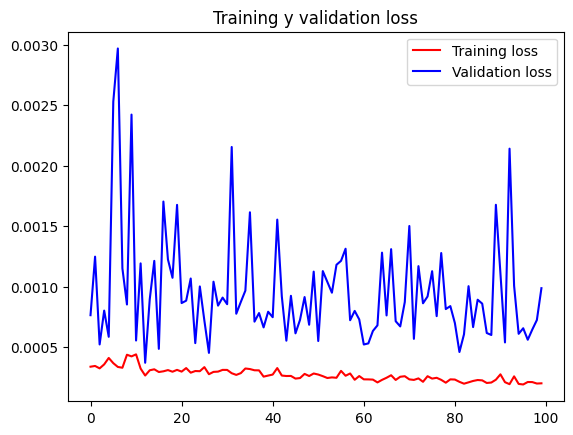

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training y validation loss')
plt.legend(loc=0)
plt.figure()


plt.show()

In [ ]:
### Lets Do the prediction and check performance metrics
train_predict=best_model_busq_aleatoria.predict(train_X)
test_predict=best_model_busq_aleatoria.predict(test_X)
train_predict.shape, test_predict.shape

39/39 [==============================] - 1s 15ms/step


((3714, 1), (1235, 1))

In [ ]:
# Transform back to original form

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(train_y.reshape(-1,1)) 
original_ytest = scaler.inverse_transform(test_y.reshape(-1,1))

In [ ]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

In [ ]:
# Evaluation metrices RMSE, MAE and MAPE
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MAPE: ", mape(original_ytrain,train_predict))
print("Train data MAE: ", mean_absolute_error(original_ytrain,train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MAPE: ", mape(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))

Train data RMSE:  15.907678939844637
Train data MAPE:  0.9419993451256418
Train data MAE:  11.218424909732386
-------------------------------------------------------------------------------------
Test data RMSE:  45.90320122394428
Test data MAPE:  1.6295634944568154
Test data MAE:  29.405981957711276


In [ ]:
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Precio original','Precio predecido Train','Precio predecido Test'])


plotdf = pd.DataFrame({'date': close_stock['Time'],
                       'original_close': close_stock['Close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Precio (USD)','date': 'Fecha'})
fig.update_layout(title_text='Comparación entre precio original de cierre y precio predecido de cierre',
                  plot_bgcolor='white', font_size=14, font_color='black', legend_title_text='Precio cierre')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (4961, 1)
Test predicted data:  (4961, 1)
